In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
allstations = pd.read_csv('./nomenclature_2024.csv', index_col=2)
allstations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, GDL-001 to GDL-253
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         372 non-null    int64  
 1   name       372 non-null    object 
 2   location   372 non-null    object 
 3   latitude   372 non-null    float64
 4   longitude  372 non-null    float64
 5   status     372 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 20.3+ KB


Mean of selected stations: 20.680915985000002, -103.365041285


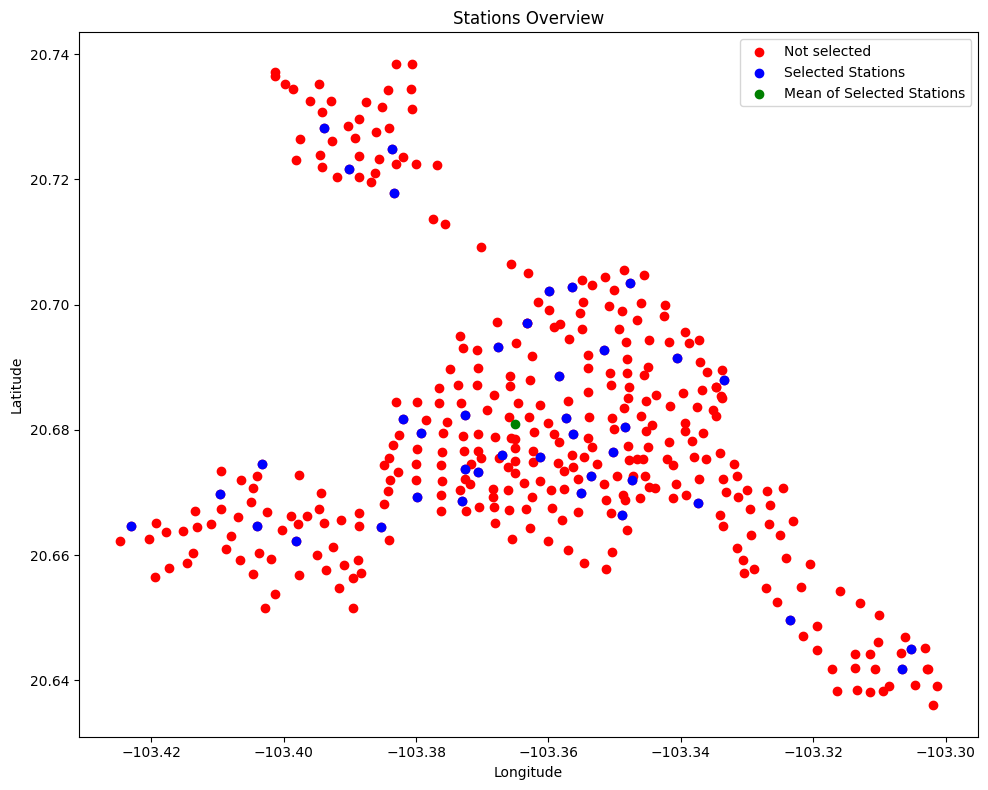

In [391]:
# Select 20 stations for 20/80 ds split
selectedStations = allstations.sample(40, random_state=42)

# Plot the stations
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all stations in red
ax.scatter(allstations['longitude'], allstations['latitude'], marker='o', color='red', label='Not selected')

# Plot selected stations in blue
ax.scatter(selectedStations['longitude'], selectedStations['latitude'], marker='o', color='blue', label='Selected Stations')

selectedStationsMean = selectedStations[['latitude', 'longitude']].mean()
ax.scatter(selectedStationsMean['longitude'], selectedStationsMean['latitude'], marker='o', color='green', label='Mean of Selected Stations')

print(f"Mean of selected stations: {selectedStationsMean['latitude']}, {selectedStationsMean['longitude']}")

ax.set_title('Stations Overview')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.tight_layout()
plt.show()

In [438]:
trips = pd.read_csv('./trips_engineered.csv', usecols=[
    'Origin_Id',
    'Day',
    'Month',
    'Year',
    'Distance',
    'Duration'
])

In [439]:
filtered_trips = trips[(trips['Duration'] > 1) | (trips['Distance'] != 0)]
print(f"Trips before filter: {trips.count()}")
print(f"Trips after filter: {filtered_trips.count()}")

Trips before filter: Origin_Id    25863690
Day          25863690
Month        25863690
Year         25863690
Duration     25863690
Distance     25863652
dtype: int64
Trips after filter: Origin_Id    25773601
Day          25773601
Month        25773601
Year         25773601
Duration     25773601
Distance     25773563
dtype: int64


In [ ]:
filtered_trips['Time'] = pd.to_datetime(trips[['Year', 'Month', 'Day']])

In [ ]:
selectedTrips = filtered_trips[trips['Origin_Id'].isin(selectedStations['id'])]

In [428]:
weather = pd.read_csv('./mini-meteo.csv')

In [429]:
demand = selectedTrips.groupby(['Origin_Id', 'Time']).agg(
    Departures=('Origin_Id', 'size'),
    Avg_trip_distance=('Distance', 'mean')
)
demand.reset_index(inplace=True)
demand.rename(columns={'Origin_Id': 'Station_id'}, inplace=True)

In [430]:
weather['Time'] = pd.to_datetime(weather['time'])
weather.drop(columns=['time'], inplace=True)

In [432]:
# Create a DataFrame with all unique combinations of Station_id and Time from the weather DataFrame
all_dates = pd.DataFrame({
    'Time': weather['Time'].unique()
}).merge(
    demand[['Station_id']].drop_duplicates(),
    how='cross'
)

# Merge the demand DataFrame with the all_dates DataFrame to find missing dates
demand_complete = all_dates.merge(demand, on=['Station_id', 'Time'], how='left')

# Fill missing values with 0 for Departures and Avg_trip_distance
demand_complete.fillna(0, inplace=True)

# Merge the demand_complete DataFrame with the weather DataFrame
merged_df = demand_complete.merge(weather, on='Time', how='left')

Text(0.5, 1.0, 'Viajes de la estación 2 (Color para temperatura)')

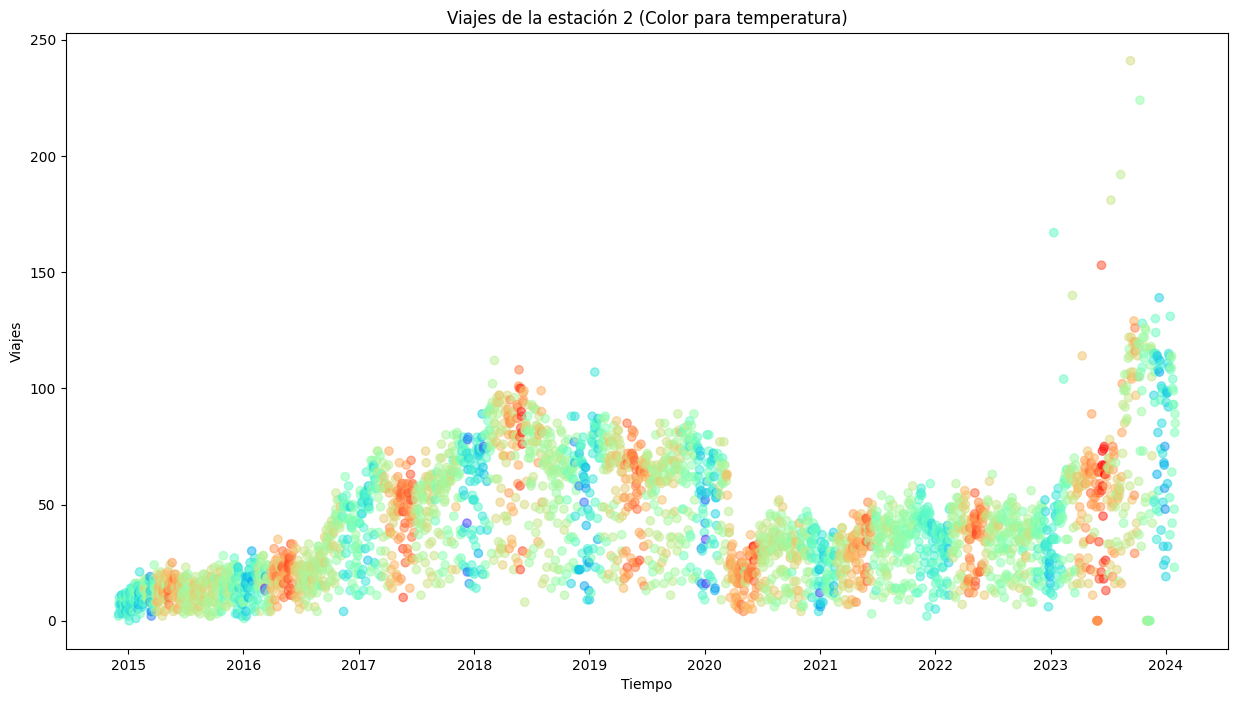

In [630]:
stationid = 2
stationdf = merged_df[merged_df['Station_id'] == stationid]

fig, ax = plt.subplots(figsize=(15, 8))

ax.scatter(stationdf['Time'], stationdf['Departures'], c=stationdf['temperature_2m_mean (°C)'], cmap='rainbow', alpha=0.5)

ax.set_xlabel('Tiempo')
ax.set_ylabel('Viajes')
plt.title('Viajes de la estación 2 (Color para temperatura)')

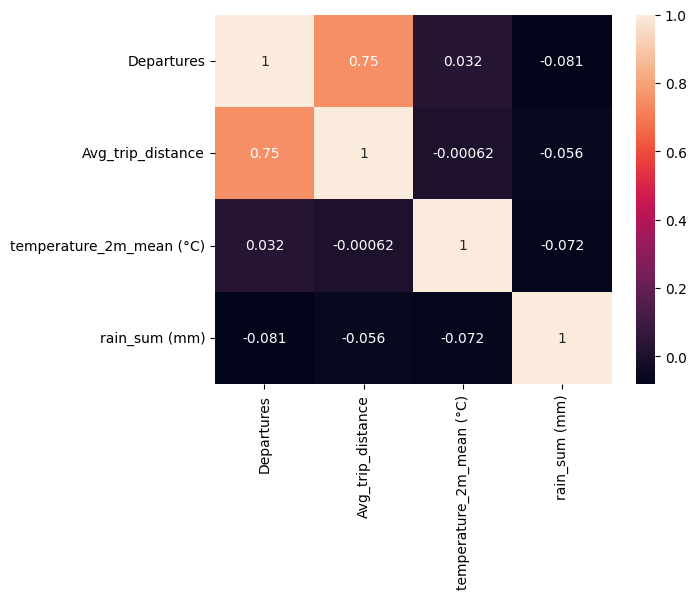

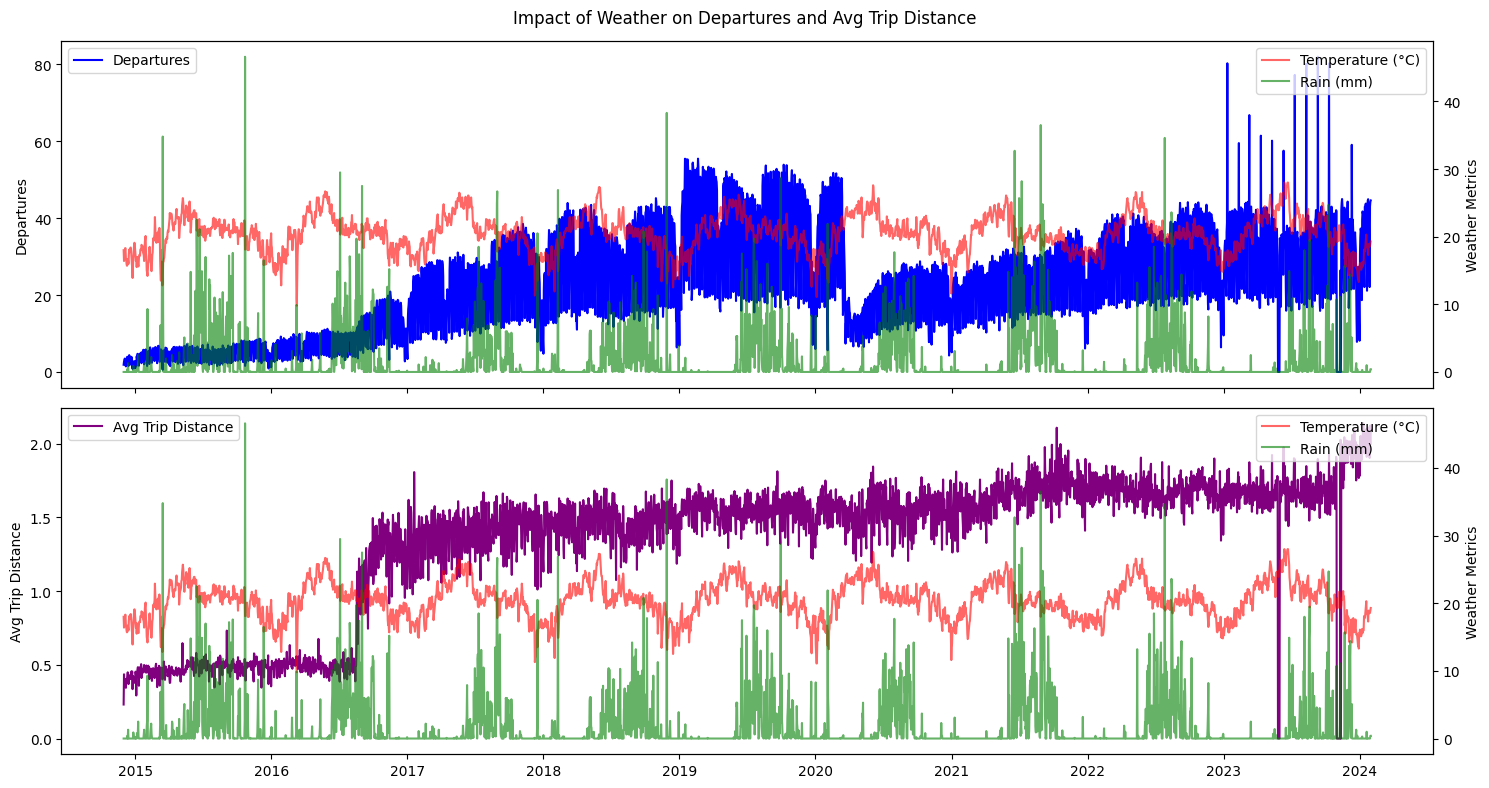

In [550]:
# Resample data to daily averages
daily_data = merged_df.groupby('Time').agg({
    'Departures': 'mean',
    'Avg_trip_distance': 'mean',
    'temperature_2m_mean (°C)': 'mean',
    'rain_sum (mm)': 'mean'
})

# Calculate correlation matrix
correlation = daily_data.corr()
sns.heatmap(correlation, annot=True)

# Plot time series data
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Plot Departures vs Weather
ax1 = axes[0]
ax1.plot(daily_data.index, daily_data['Departures'], label='Departures', color='blue')
ax1.set_ylabel('Departures')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['temperature_2m_mean (°C)'], label='Temperature (°C)', color='red', alpha=0.6)
ax2.plot(daily_data.index, daily_data['rain_sum (mm)'], label='Rain (mm)', color='green', alpha=0.6)
ax2.set_ylabel('Weather Metrics')
ax2.legend(loc='upper right')

# Plot Avg Trip Distance vs Weather
ax3 = axes[1]
ax3.plot(daily_data.index, daily_data['Avg_trip_distance'], label='Avg Trip Distance', color='purple')
ax3.set_ylabel('Avg Trip Distance')
ax3.legend(loc='upper left')

ax4 = ax3.twinx()
ax4.plot(daily_data.index, daily_data['temperature_2m_mean (°C)'], label='Temperature (°C)', color='red', alpha=0.6)
ax4.plot(daily_data.index, daily_data['rain_sum (mm)'], label='Rain (mm)', color='green', alpha=0.6)
ax4.set_ylabel('Weather Metrics')
ax4.legend(loc='upper right')

plt.xlabel('Time')
plt.suptitle('Impact of Weather on Departures and Avg Trip Distance')
plt.tight_layout()
plt.show()

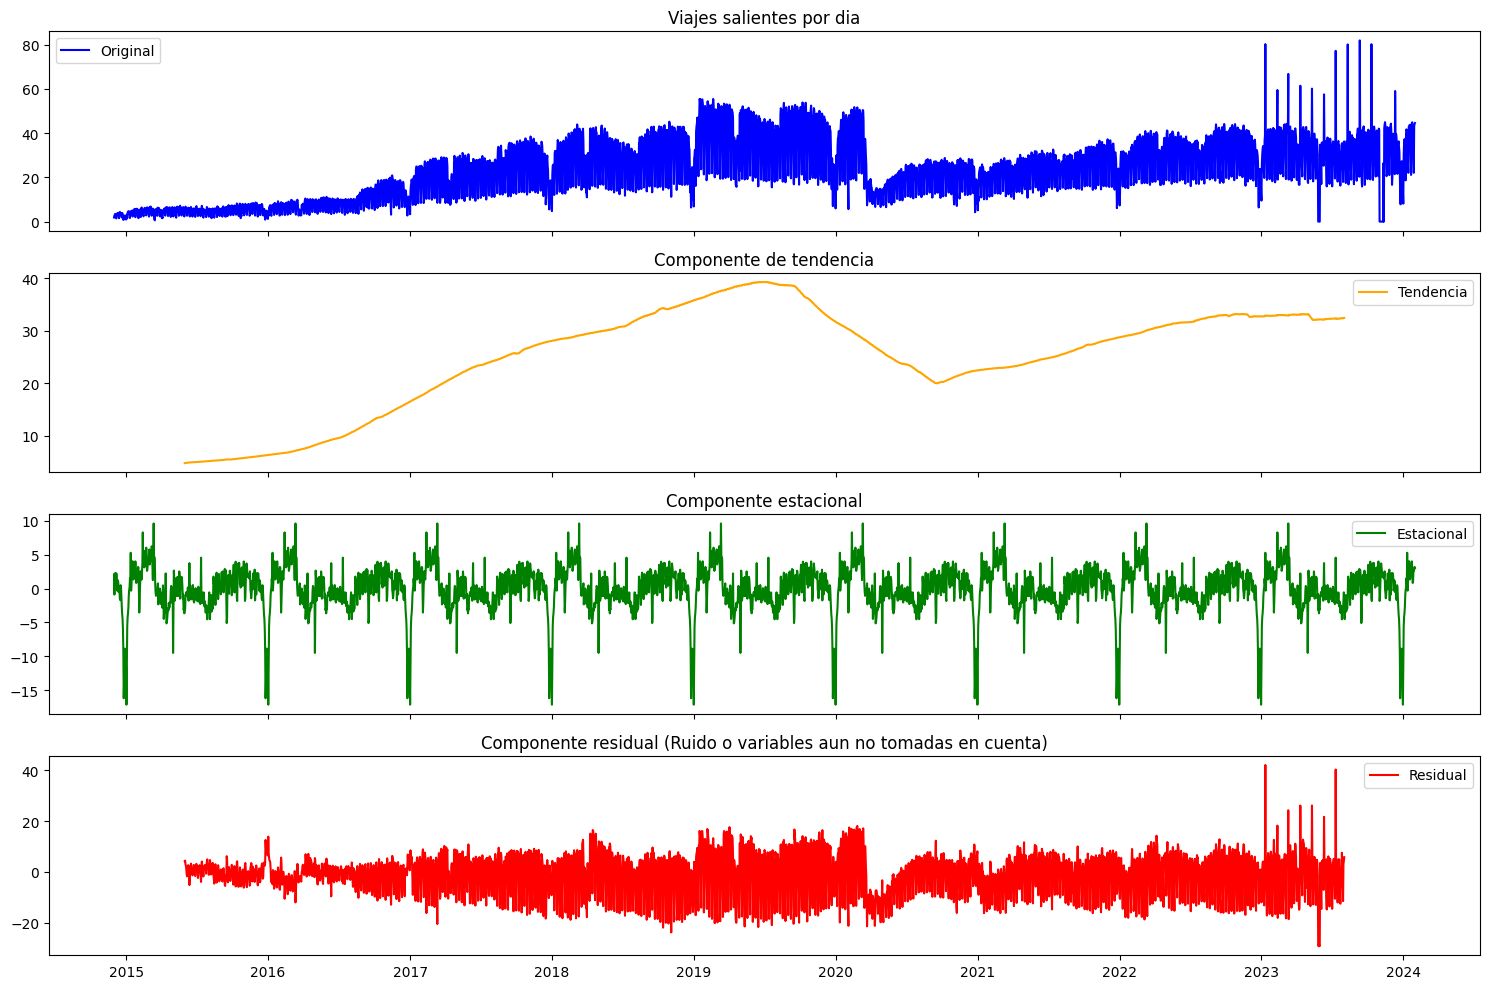

In [594]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the Departures time series
decomposition = seasonal_decompose(daily_data['Departures'], model='additive', period=365)

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

axes[0].plot(daily_data.index, daily_data['Departures'], label='Original', color='blue')
axes[0].set_title('Viajes salientes por dia')
axes[0].legend()

axes[1].plot(decomposition.trend, label='Tendencia', color='orange')
axes[1].set_title('Componente de tendencia')
axes[1].legend()

axes[2].plot(decomposition.seasonal, label='Estacional', color='green')
axes[2].set_title('Componente estacional')
axes[2].legend()

axes[3].plot(decomposition.resid, label='Residual', color='red')
axes[3].set_title('Componente residual (Ruido o variables aun no tomadas en cuenta)')
axes[3].legend()

plt.tight_layout()
plt.show()

In [553]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [616]:
features = ['temperature_2m_mean (°C)', 'rain_sum (mm)']

In [617]:
# Prepare the data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_data[features])

In [618]:
# Define a function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])  # Use all features except the last one as input
        y.append(data[i + sequence_length, 0])  # Predict 'Departures'
    return np.array(X), np.array(y)

sequence_length = 30  # Use the past 30 days to predict the next day
X, y = create_sequences(scaled_data, sequence_length)

In [619]:
# Split into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [620]:
# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Train the model
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0576 - val_loss: 0.0075
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0081 - val_loss: 0.0050
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0076 - val_loss: 0.0051
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0047 - val_l

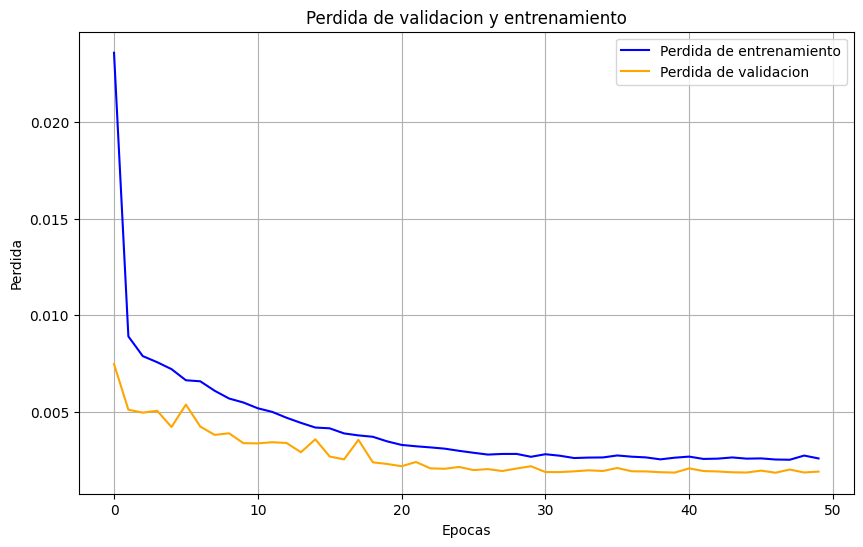

In [621]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perdida de entrenamiento', color='blue')
plt.plot(history.history['val_loss'], label='Perdida de validacion', color='orange')
plt.title('Perdida de validacion y entrenamiento')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Validation Loss: 0.0018583588534966111


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


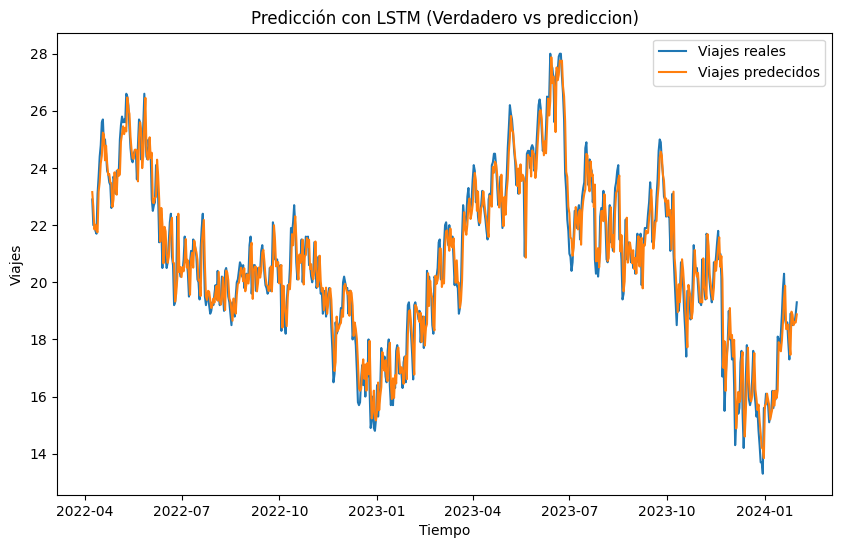

In [622]:
# Evaluate the model

model.load_weights('best_model.keras')

# Evaluate the model
val_loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")

# Make predictions
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index[-len(y_val):], scaler.inverse_transform(scaled_data[-len(y_val):])[:, 0], label='Viajes reales')
plt.plot(daily_data.index[-len(y_val):], predictions, label='Viajes predecidos')
plt.legend()
plt.title('Predicción con LSTM (Verdadero vs prediccion)')
plt.xlabel('Tiempo')
plt.ylabel('Viajes')
plt.show()

In [623]:
print(selectedStations['id'].tolist())

[343, 36, 18, 330, 60, 249, 79, 128, 321, 135, 242, 42, 162, 58, 164, 289, 2, 240, 351, 106, 12, 189, 75, 247, 266, 146, 234, 203, 202, 385, 28, 113, 45, 376, 304, 119, 66, 25, 161, 185]


 57/104 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


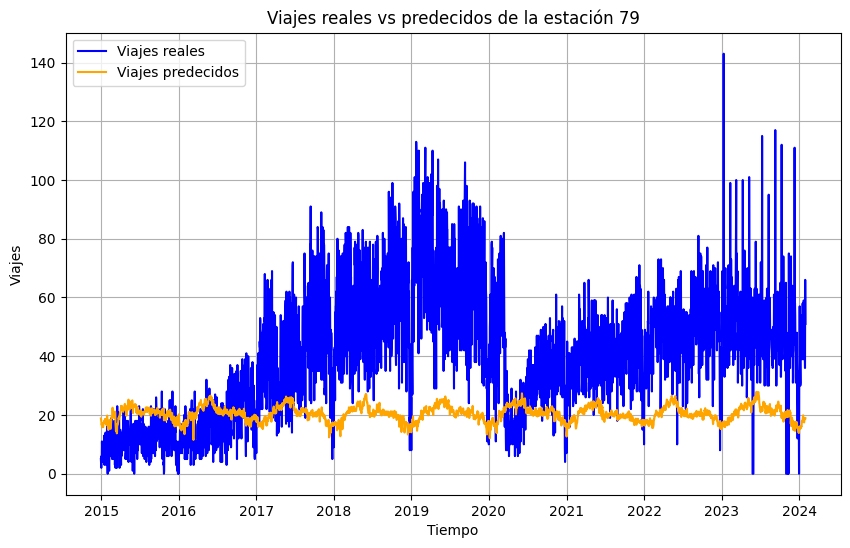

In [624]:
# Filter data for station 2
stationID = 79

station_test_data = merged_df[merged_df['Station_id'] == stationID]

# Scale the data
test_data_scaled = scaler.transform(station_test_data[features])

# Create sequences for station 2
X_station_2, _ = create_sequences(test_data_scaled, sequence_length)

# Predict departures
test_predictions = model.predict(X_station_2)

# Inverse transform the predictions
test_predictions = scaler.inverse_transform(
    np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], test_data_scaled.shape[1] - 1))), axis=1)
)[:, 0]

# Add predictions to the original data
station_test_data = station_test_data.iloc[sequence_length:].copy()
station_test_data['Predicted_Departures'] = test_predictions

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(station_test_data['Time'], station_test_data['Departures'], label='Viajes reales', color='blue')
plt.plot(station_test_data['Time'], station_test_data['Predicted_Departures'], label='Viajes predecidos', color='orange')
plt.title(f'Viajes reales vs predecidos de la estación {stationID}')
plt.xlabel('Tiempo')
plt.ylabel('Viajes')
plt.legend()
plt.grid(True)
plt.show()